In [9]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
$$
where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [10]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k: float

In [11]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    x_k,k =  state
    next_k = k+1
    alpha_k = 0.1/np.sqrt(next_k)
    grad = f.grad(x_k) + g.subgrad(x_k)
    x_k_next = x_k - alpha_k*grad

    return SubG_state(x_k_next,next_k)
def SubG_initialize(composite_function, x_zero):
    return SubG_state(x_zero,0)

In [12]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

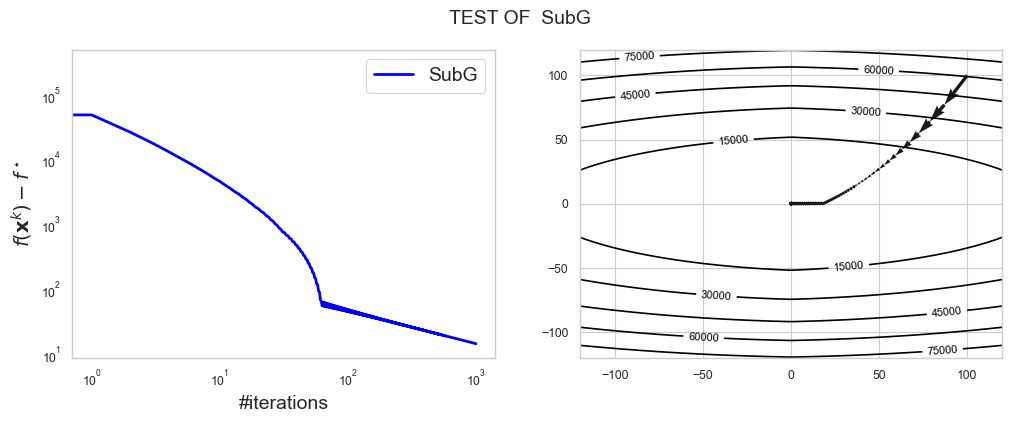

In [13]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


As seen in class (Lecture 7, slide 9), by definition:

$$
u^{*} = \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) 
= \mathrm{arg}\min_{\mathbf{u}}\left\{ g_{\ell_1}(\mathbf{u}) + \frac{1}{2\gamma}\Vert\mathbf{u} - \mathbf{z}\Vert_2^2 \right\}
= \mathrm{arg}\min_{\mathbf{u}}\left\{ \|\mathbf{u}\|_1 + \frac{1}{2\gamma}\Vert\mathbf{u} - \mathbf{z}\Vert_2^2 \right\}.
$$

With $\gamma \in \mathbb{R}_+ $, let’s call the proximal function we want to minimize:

$$
p(u) = \|\mathbf{u}\|_1 + \frac{1}{2\gamma}\Vert\mathbf{u} - \mathbf{z}\Vert_2^2.
$$

To find $u^* $, we need to find the minium of the function p such that: $ \partial p(u^*) = 0 $ where $ \partial p(u) $ is the **subdifferential** of $ p $.  
We know that this point $u^* $ will be the unique minimumof $ p(u) $ because p(u) is **strictly convex**, as the quadratic term is strictly convex when $ \gamma > 0 $ and $\|\mathbf{u}\|_1$ is an addition of convext functions, which is also convex.


### Separability:

The function $ p(u) $ is **separable** across coordinates since $ p(u)$ is the sum of the absolute value of coordinates of u ($l_1$ term) and sum of coordinate distance between u and z ($\Vert\mathbf{u} - \mathbf{z}\Vert_2^2$ term)

$
p(u) = \sum_{i=1}^{p} p_i(u_i),
$

where each component function is:

$
p_i(u_i) = |u_i| + \frac{1}{2\gamma}(u_i - z_i)^2.
$

Thus, we can minimize $ p_i(u_i) $ independently for each coordinate $ i $.


### Compute the seperated subdifferential

Because of the absolute value, we need to divide the cases, so we have or each coordinate $ i $:


$
\partial p_i(u_i) =
\begin{cases}
1 + \frac{1}{\gamma}(u_i - z_i), & \text{if } u_i > 0, \\
[-1, 1] - \frac{1}{\gamma}z_i, & \text{if } u_i = 0, \\
-1 + \frac{1}{\gamma}(u_i - z_i), & \text{if } u_i < 0.
\end{cases}
$



### Find the minimum by searching zero points of $\partial p_i(u_i^*) $

Imposing this condition gives:

$
0 = \partial p_i(u_i^*) \implies
\begin{cases}
0 = 1 + \frac{1}{\gamma}(u_i^* - z_i), & \text{if } u_i^* > 0, \\
0 \in [-1, 1] - \frac{1}{\gamma}z_i, & \text{if } u_i^* = 0, \\
0 = -1 + \frac{1}{\gamma}(u_i^* - z_i), & \text{if } u_i^* < 0.
\end{cases}
$

The first and last cases are straightforward, but for the case $ u_i^* = 0$ we need to chose the most appropriate subgradient. Since we are computing the usbgradient of an absolute value, using 0 is the best choice.
Solving each case for $ u_i^* $ gives:

$
u_i^* =
\begin{cases}
z_i - \gamma, & \text{if } z_i > \gamma, \\
0, & \text{if } -\gamma \leq z_i \leq \gamma, \\
z_i + \gamma, & \text{if } z_i < -\gamma.
\end{cases}
$


### Combine into a single expression

This piecewise definition can be written compactly as:

$
u_i^* = \max(|z_i| - \gamma, 0) \cdot \mathrm{sign}(z_i).
$

Thus, in vector form:

$
u^* = \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}| - \gamma, 0) \circ \mathrm{sign}(\mathbf{z}), \ \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
$

where all operations are applied **coordinate-wise**.


### Interpretation

This Prox-operator is sometimes called **soft thresholding**, and it penalizes values of $ \mathbf{z} $ that fall outside a certain range determined by $\gamma $. This can be seen by looking at the term $|\mathbf{z}| - \gamma$ in the max function. 

#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [14]:
def l1_prox(gamma, z):
    return np.maximum(np.abs(z)- gamma,0) * np.where(np.where(z==0,0,z) > 0,1,-1)

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method ISTA$_{\mu}$.

In [15]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    alpha: float

In [16]:
def ISTA_update(composite_function, state):
    f, g, = composite_function
    x_k, alpha = state

    next_x_k = l1_prox(alpha,x_k-alpha*f.grad(x_k))

    return ISTA_state(next_x_k,alpha)

def ISTA_initialize(composite_function, x_zero):
    f,g = composite_function
    return ISTA_state(x_zero, 2/(f.lips_grad + f.strng_cvx))



In [17]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

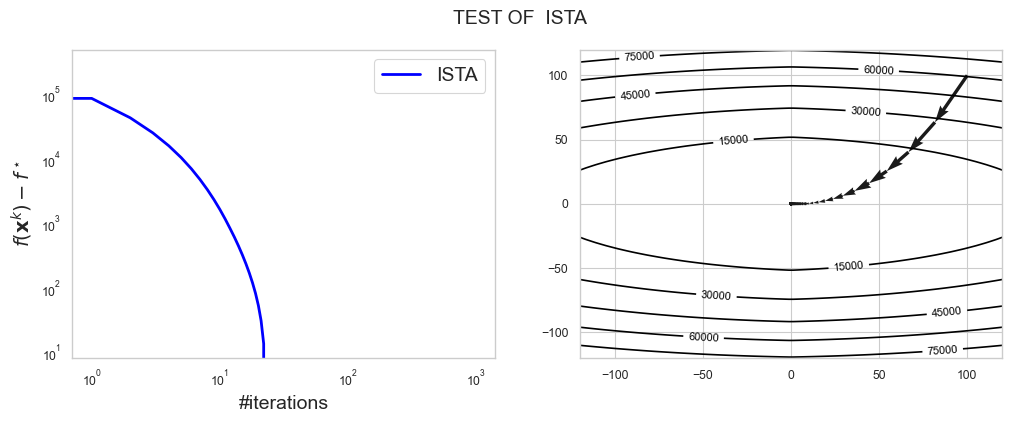

In [18]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method FISTA$_{\mu}$.

In [19]:
@dataclass
class FISTA_state(OptState):
    x_k: Vector
    y_k: Vector
    alpha: float
    c_f_term: float

In [20]:
def FISTA_update(composite_function, state):
    f, g, = composite_function
    x_k, y_k, alpha, c_f_term = state

    next_x_k = l1_prox(alpha,y_k-alpha*f.grad(y_k))
    next_y_k = next_x_k + c_f_term * (next_x_k-x_k)

    return FISTA_state(next_x_k,next_y_k,alpha,c_f_term)

def FISTA_initialize(composite_function, x_zero):
    f,g = composite_function
    alpha = 1/f.lips_grad
    c_f = f.lips_grad/f.strng_cvx
    c_f_term = (np.sqrt(c_f)-1)/(np.sqrt(c_f)+1)
    return FISTA_state(x_zero, x_zero, alpha, c_f_term)



In [21]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

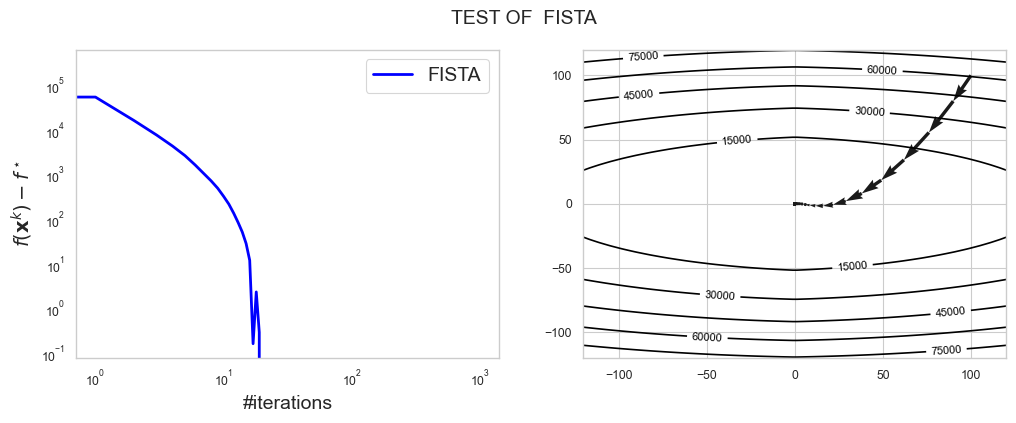

In [22]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

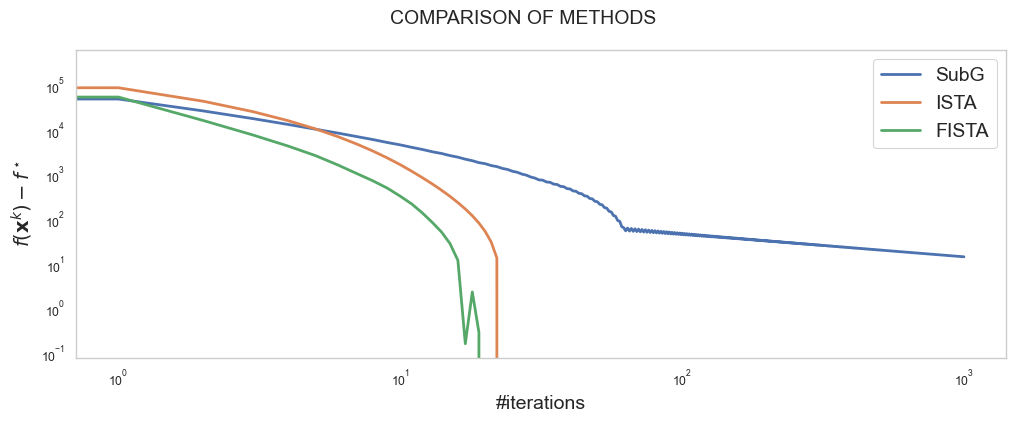

In [23]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

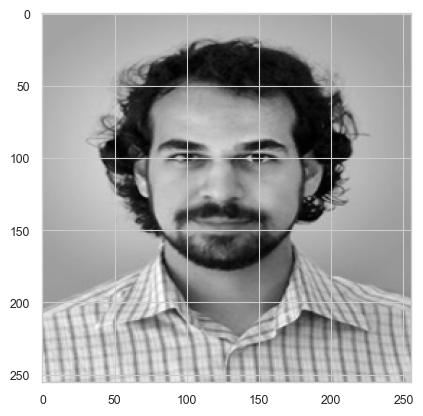

In [24]:
from lib.inpainting import *

image = load("/Users/mattice/Desktop/Assignement1Maths/lib/alp.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

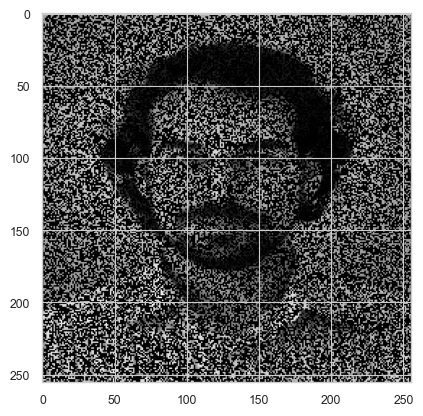

In [25]:
subsampled = show_subsampled(image)

To enforce $\mu$-strong convexity, an $\ell_2$ regularization term is added to the smooth component :

$$
f_{\ell_1}(\boldsymbol{\alpha}) 
= \tfrac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega}\mathbf{W}^\top\boldsymbol{\alpha}\|_2^2 
+ \tfrac{\mu}{2}\|\boldsymbol{\alpha}\|_2^2,
$$

and the resulting composite objective is

$$
\min_{\boldsymbol{\alpha}} 
f_{\ell_1}(\boldsymbol{\alpha}) + g_{\ell_1}(\boldsymbol{\alpha}),
\quad \text{where } 
g_{\ell_1}(\boldsymbol{\alpha}) = \lambda_{\ell_1}\|\boldsymbol{\alpha}\|_1.
$$


In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [26]:
from lib.inpainting import P, P_T, W

x = image.reshape(-1) 


b = P(x)

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [27]:
mu = 1e-4 
def f_l1(alpha):
    """Smooth part: 1/2 || b - P W_T alpha ||^2 + 1/2 mu ||alpha||^2"""
    recon = P(W_T(alpha))
    res = b - recon
    return 0.5 * np.linalg.norm(res)**2 + 0.5 * mu * np.linalg.norm(alpha)**2

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [28]:
def grad_f_l1(alpha):
    """Gradient: A^T(A alpha - b) + mu*alpha where A = P o W_T."""
    residual = P(W_T(alpha)) - b

    return W(P_T(residual)) + mu * alpha

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

 the Lipschitz constant of

$$
f(\mathbf{x}) = \frac{1}{2}\|\mathbf{b} - \mathbf{A}\mathbf{x}\|_2^2 + \frac{\rho}{2}\|\mathbf{x}\|_2^2
$$

is

$$
L = \lambda_1(\mathbf{A}^\top \mathbf{A}) + \rho.
$$

In our case, $\rho = \mu$ and $\mathbf{A} = \mathbf{P}_{\Omega}\mathbf{W}^\top$, hence

$$
L = \lambda_1(\mathbf{W}\mathbf{P}_{\Omega}^\top \mathbf{P}_{\Omega}\mathbf{W}^\top) + \mu.
$$

We also know that $\mathbf{P}_{\Omega}$ contains rows of the identity matrix. Therefore,

$$
\mathbf{P}_{\Omega}^\top \mathbf{P}_{\Omega} = \mathbf{D}_{\Omega},
$$

where $\mathbf{D}_{\Omega}$ is a diagonal matrix with entries equal to $1$ or $0$.

Since $\mathbf{W}$ is **orthogonal**, it preserves eigenvalues:

$$
\lambda_1(\mathbf{W}\mathbf{P}_{\Omega}^\top \mathbf{P}_{\Omega}\mathbf{W}^\top)
= \lambda_1(\mathbf{W}\mathbf{D}_{\Omega}\mathbf{W}^\top)
= \lambda_1(\mathbf{D}_{\Omega})
= 1.
$$

Hence, the Lipschitz constant is

$$
L = 1 + \mu.
$$


In [29]:

lips_grad_f_l1 = 1.0 + mu

We have all the necessary ingredients to define the smooth part of our composite objective:

In [30]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [31]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [32]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [33]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

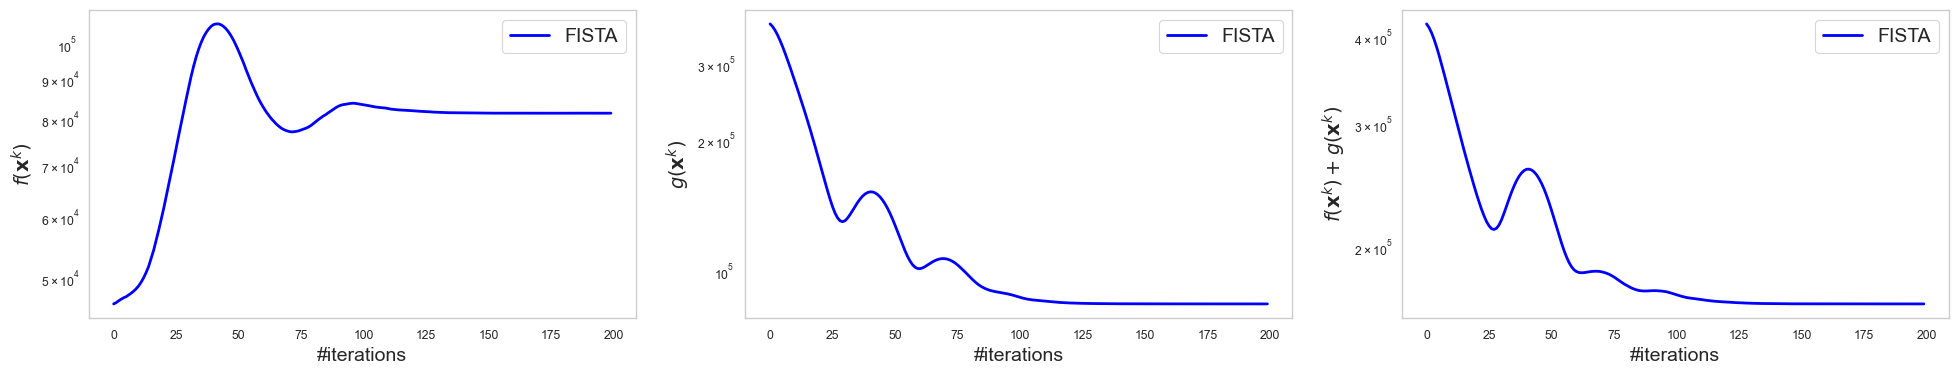

In [34]:
# Solve for alpha using a chosen method 
lmda = 0.1
max_iter = 200
output = solve_composite(FISTA, composite_objective, lmda=lmda, max_iterations=max_iter)

flat_image_out = W_T(output)
image_out = flat_image_out.reshape(256, 256)

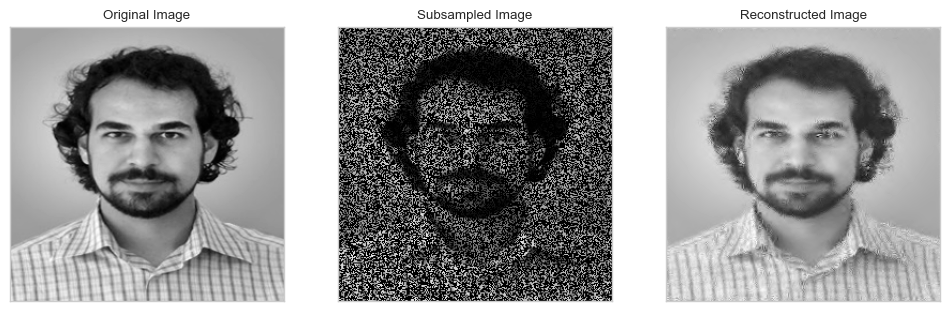

In [35]:
show(true = image, subsampled=subsampled, estimated=image_out)